# Maine Blackout Data Analysis

In [125]:
# importing required libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

# set options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

### Import and clean data

In [126]:
# importing data
df = pd.read_csv('../data/Maine_Power.csv')

# drop all entries with an unknown county or no customer hours tracked
county_df = df.copy(deep=True)
county_df.drop(county_df[county_df['CountyName'] == "Unknown"].index, inplace=True)
county_df.drop(county_df[county_df['CustomerHoursTrackedTotal']  <= 0].index, inplace=True)
# Use the max of 'MaxCustomerOut' and 'AvgCustomersTracked' to account for cases where 
# 'maxcustomersout' exceeds 'avgcustomerstracked', which likely indicates underreporting 
# of tracked customers.
county_df['Customers'] = df[['MaxCustomersOut', 'AvgCustomersTracked']].max(axis=1)
df['Customers'] = df[['MaxCustomersOut', 'AvgCustomersTracked']].max(axis=1)
df.drop(county_df[county_df['CustomerHoursTrackedTotal']  <= 0].index, inplace=True)

### Table of the yearly average outage hours per customer by county

In [127]:
# sum up all the customers tracked and total customer hours by month and county
county_monthly_df = county_df.groupby(['CountyName', 'RecordYear', 'RecordMonth']).agg({'CustomerHoursOutTotal': 'sum', 'Customers': 'sum', 'UtilityName': lambda x: ', '.join(x.unique())}).reset_index()

# sum up total customer hours out by year and county and average the customers tracked (to avoid double counting)
yearly_df = county_monthly_df.groupby(['CountyName', 'RecordYear']).agg({'CustomerHoursOutTotal': 'sum', 'Customers': 'mean', 'UtilityName': lambda x: ', '.join(x.unique())}).reset_index()

# get the yearly outage hours per customer for each county
yearly_df['OutageHoursPerCustomer'] = yearly_df['CustomerHoursOutTotal'] / yearly_df['Customers']

# create a final table with the relevant columns
df_yearly_cust_outage = yearly_df[['CountyName', 'RecordYear', 'OutageHoursPerCustomer', 'UtilityName']]

# sort by county and year
df_yearly_cust_outage.sort_values(by=['CountyName', 'RecordYear'], inplace=True)

# rename columns to be more readable
df_yearly_cust_outage.rename(columns={"CountyName": "County", "RecordYear": "Year", "OutageHoursPerCustomer": "Average Outage Hours per Customer"}, inplace=True)

# export and show dataframe
df_yearly_cust_outage.to_csv("exports/maine-county-yearly-out-hours-per-cust.csv", sep=',', encoding='utf-8', index=False, header=True)
df_yearly_cust_outage

,County,Year,Average Outage Hours per Customer,UtilityName
0,Androscoggin,2016,1.220995,Central Maine Power
1,Androscoggin,2017,3.072334,Central Maine Power
2,Androscoggin,2018,6.842007,Central Maine Power
3,Androscoggin,2019,5.366025,Central Maine Power
4,Androscoggin,2020,31.444888,Central Maine Power
5,Androscoggin,2021,2.971081,Central Maine Power
6,Androscoggin,2022,18.555735,Central Maine Power
7,Androscoggin,2023,4.462402,Central Maine Power
8,Aroostook,2017,57.334279,Versant Power
9,Aroostook,2018,32.279400,"Versant Power, Versant Power, Eastern Maine Po..."


### Create a choropleth map of average outage hours per customer by county

In [128]:
# Aroostok county only has data from 2017 onwards, removing data from 2016 and earlier for consistency
yearly_df.drop(yearly_df[yearly_df['RecordYear'] <= 2016].index, inplace=True)

# Function that removes duplicate utility providers from entries
def remove_duplicate_providers(providers_str):
    providers = set(provider.strip() for provider in providers_str.split(', '))
    return ', '.join(sorted(providers))

# get the overall yearly average outage hours per customer by county
overall_county_outage_df = yearly_df.groupby(['CountyName']).agg({'OutageHoursPerCustomer': 'mean', 'UtilityName': lambda x: ', '.join(x.unique())}).reset_index()

# when aggregated, duplicate utility providers sometimes appear - remove all duplicates
overall_county_outage_df["UtilityName"] = overall_county_outage_df["UtilityName"].apply(remove_duplicate_providers)

# sort county names alphabetically
overall_county_outage_df.sort_values(by=['CountyName'], inplace=True)

#rename columns to be more readable
overall_county_outage_df.rename(columns={"CountyName": "County", "OutageHoursPerCustomer": "Overall Yearly Average Outage Hours per Customer (2017 - 2023)", "UtilityName": "Utility Provider(s)"}, inplace=True)

# export and show dataframe
overall_county_outage_df.to_csv("exports/maine-county-overall-out-hours-per-cust.csv", sep=',', encoding='utf-8', index=False, header=True)
overall_county_outage_df

,County,Overall Yearly Average Outage Hours per Customer (2017 - 2023),Utility Provider(s)
0,Androscoggin,10.387782,Central Maine Power
1,Aroostook,18.002159,"Eastern Maine Power Cooperative, Versant Power"
2,Cumberland,10.664610,Central Maine Power
3,Franklin,19.398950,Central Maine Power
4,Hancock,25.809872,"Central Maine Power, Versant Power"
5,Kennebec,11.146684,Central Maine Power
6,Knox,14.728109,Central Maine Power
7,Lincoln,23.442714,Central Maine Power
8,Oxford,20.011233,Central Maine Power
9,Penobscot,17.990396,"Central Maine Power, Eastern Maine Power Coope..."


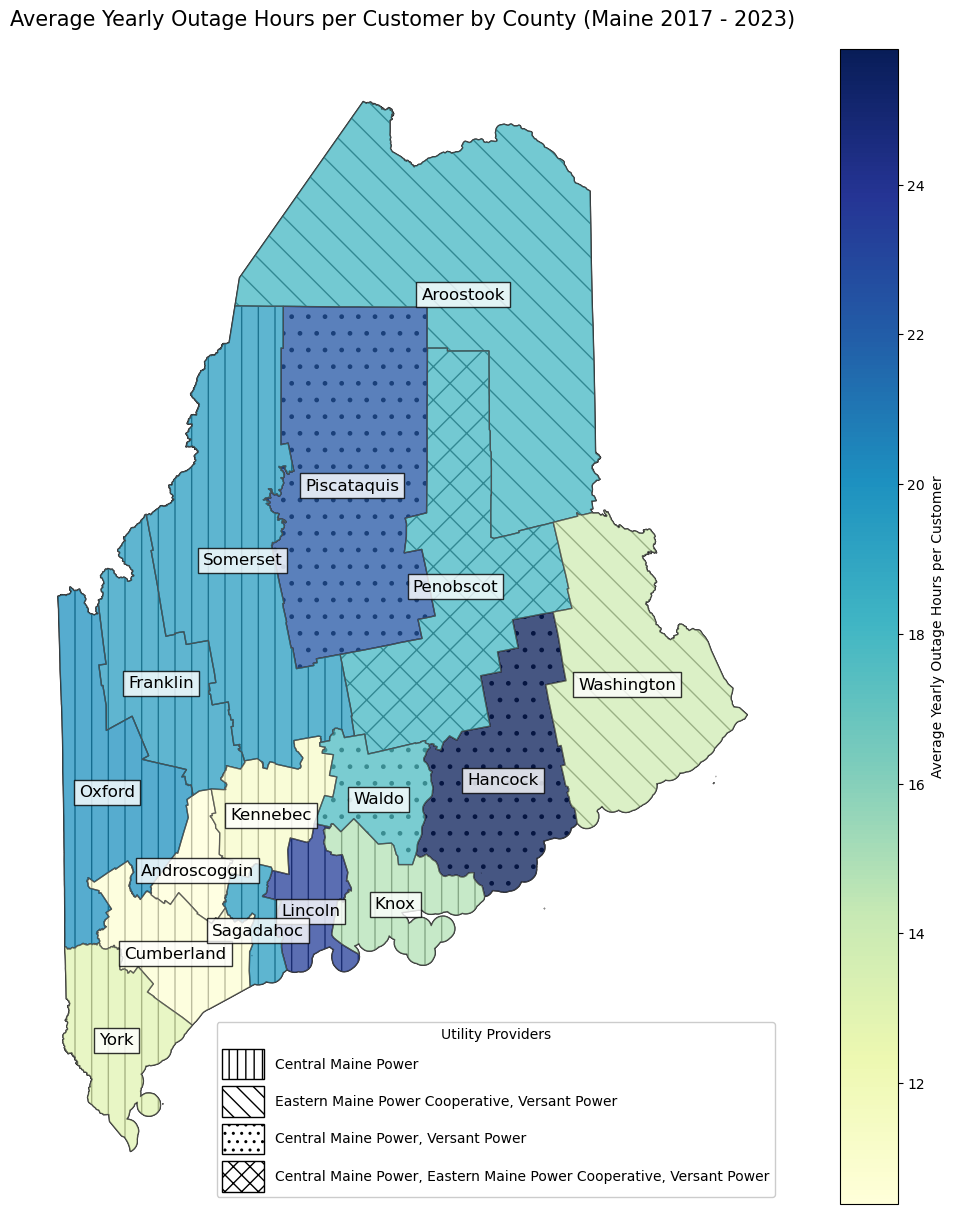

In [129]:
# import county boundaries
counties = gpd.read_file('../data/Maine_County_Boundary_Polygons_Dissolved_Feature.shp')

# merge county outage hours per customer data with geospatial data
merged = counties.set_index('COUNTY').join(overall_county_outage_df.set_index('County'))

# configure the plot size
fig, ax = plt.subplots(figsize=(15, 15))
# add hatches for different utility providers
merged.loc[merged['Utility Provider(s)'] == 'Central Maine Power'].plot(facecolor=(0, 0, 0, 0), hatch="|", edgecolor="0", ax=ax)
merged.loc[merged['Utility Provider(s)'] == 'Eastern Maine Power Cooperative, Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch="\\", edgecolor="0", ax=ax)
merged.loc[merged['Utility Provider(s)'] == 'Central Maine Power, Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch=".", edgecolor="0", ax=ax)
merged.loc[merged['Utility Provider(s)'] == 'Central Maine Power, Eastern Maine Power Cooperative, Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch="x", edgecolor="0", ax=ax)
# plot the choropleth map using the outage hours per customer as a variable
merged.plot(column='Overall Yearly Average Outage Hours per Customer (2017 - 2023)', alpha=0.75, cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True, legend_kwds={'label': "Average Yearly Outage Hours per Customer", 'orientation': "vertical"})

# create custom legend of the hatches used
hatch_legend = [
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="||", label="Central Maine Power"),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="\\\\", label="Eastern Maine Power Cooperative, Versant Power"),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="..", label="Central Maine Power, Versant Power"),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="xx", label="Central Maine Power, Eastern Maine Power Cooperative, Versant Power"),
]

# add the legend to the plot
hatch_legend = ax.legend(handles=hatch_legend, title="Utility Providers", handleheight=3, handlelength=3, loc="lower right")
hatch_legend.get_frame().set_facecolor('white')
hatch_legend.get_frame().set_alpha(1)

# add county name labels
for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged.index):
    ax.text(x, y, label, fontsize=12, ha='center', va='top', bbox=dict(boxstyle='square', facecolor='white', alpha=0.8))

# axis customization
ax.set_title('Average Yearly Outage Hours per Customer by County (Maine 2017 - 2023)', fontdict={'fontsize': '15', 'fontweight' : '3'}, loc='center')
ax.axis('off')

# save the map and display it within the notebook
plt.savefig('exports/maine-county-map-overall-out-hours-per-cust.png', dpi=300)
plt.show()

### Calculate average outage hours per customer by utility provider

#### Using the sample mean of the yearly city outage hours

In [130]:
# Create a unique identifier for each unknown entry
df['CityName'] = df.apply(
    lambda row: f"Unknown_{row['RecordYear']}_{row['RecordMonth']}" if row['CityName'] == 'Unknown' else row['CityName'], 
    axis=1
)

# sum up all the customers tracked and total customer hours by month and utility provider
monthly_city_df = df[['UtilityName', 'CityName', 'RecordYear', 'RecordMonth', 'CustomerHoursOutTotal', 'Customers']]

# sum up total customer hours out by year and utility provider and average the customers tracked (to avoid double counting)
yearly_city_df = monthly_city_df.groupby(['UtilityName', 'RecordYear', 'CityName']).agg({'CustomerHoursOutTotal': 'sum', 'Customers': 'mean'}).reset_index()

yearly_city_df['OutageHoursPerCustomer'] = yearly_city_df['CustomerHoursOutTotal'] / yearly_city_df['Customers']

yearly_city_df
# Apply log transformation (log1p adds 1 to avoid log(0))
yearly_city_df['LogOutageHours'] = np.log1p(yearly_city_df['OutageHoursPerCustomer'])

# Z-score for 95% confidence interval (1.96 for 95% CI)
z = 1.96

# Group by UtilityProvider and Year
results = []

for (provider, year), group in yearly_city_df.groupby(['UtilityName', 'RecordYear']):
    # Calculate log-transformed mean and standard deviation
    log_mean = np.mean(group['LogOutageHours'])
    log_std = np.std(group['LogOutageHours'], ddof=1)  # ddof=1 for sample std dev
    
    # Sample size
    n = len(group['LogOutageHours'])
    
    # Calculate SEM (Standard Error of the Mean)
    sem = log_std / np.sqrt(n)
    
    # Calculate confidence interval on log scale
    ci_lower_log = log_mean - z * sem
    ci_upper_log = log_mean + z * sem
    
    # Convert mean and CI back to original scale
    mean_original = np.expm1(log_mean)
    ci_lower_original = np.expm1(ci_lower_log)
    ci_upper_original = np.expm1(ci_upper_log)
    
    # Append the results for each group
    results.append({
        'UtilityProvider': provider,
        'Year': year,
        'MeanOutageHours': mean_original,
        'CI_Lower': ci_lower_original,
        'CI_Upper': ci_upper_original
    })

# Create a new DataFrame to store the results
results_df = pd.DataFrame(results)

# Eastern Maine Power Cooperative only has data from 2018 onwards, removing data from 2017 and earlier for consistency
results_df.drop(results_df[results_df['Year'] <= 2017].index, inplace=True)

# get the overall yearly average outage hours per customer by utility provider
utility_city_cust_outage_df = results_df.groupby(['UtilityProvider']).agg({'MeanOutageHours': 'mean'}).reset_index()

# sort utility names alphabetically
utility_city_cust_outage_df.sort_values(by=['UtilityProvider'], inplace=True)

# rename columns to be more readable
utility_city_cust_outage_df.rename(columns={"UtilityProvider": "Utility Provider", "MeanOutageHours": "Average Yearly Outage Hours per Customer (2018 - 2023)"}, inplace=True)

# export and show dataframe
utility_city_cust_outage_df.to_csv("exports/sample-avg-maine-utility-yearly-out-hours-per-cust.csv", sep=',', encoding='utf-8', index=False, header=True)
utility_city_cust_outage_df

,Utility Provider,Average Yearly Outage Hours per Customer (2018 - 2023)
0,Central Maine Power,17.617989
1,Eastern Maine Power Cooperative,2.586873
2,Versant Power,14.629932


#### Directly calculating at the utility provider level

In [131]:
# sum up all the customers tracked and total customer hours by month and utility provider
monthly_utility_df = df.groupby(['UtilityName', 'RecordYear', 'RecordMonth']).agg({'CustomerHoursOutTotal': 'sum', 'Customers': 'sum'}).reset_index()

# sum up total customer hours out by year and utility provider and average the customers tracked (to avoid double counting)
yearly_utility_df = monthly_utility_df.groupby(['UtilityName', 'RecordYear']).agg({'CustomerHoursOutTotal': 'sum', 'Customers': 'mean'}).reset_index()

# get the yearly outage hours per customer for each utility provider
yearly_utility_df['OutageHoursPerCustomer'] = yearly_utility_df['CustomerHoursOutTotal'] / yearly_utility_df['Customers']

# Eastern Maine Power Cooperative only has data from 2018 onwards, removing data from 2017 and earlier for consistency
yearly_utility_df.drop(yearly_utility_df[yearly_utility_df['RecordYear'] <= 2017].index, inplace=True)

# get the overall yearly average outage hours per customer by utility provider
utility_cust_outage_df = yearly_utility_df.groupby(['UtilityName']).agg({'OutageHoursPerCustomer': 'mean'}).reset_index()

# sort utility names alphabetically
utility_cust_outage_df.sort_values(by=['UtilityName'], inplace=True)

# rename columns to be more readable
utility_cust_outage_df.rename(columns={"UtilityName": "Utility Provider", "OutageHoursPerCustomer": "Overall Yearly Outage Hours per Customer (2018 - 2023)"}, inplace=True)

# export and show dataframe
utility_cust_outage_df.to_csv("exports/direct-maine-utility-overall-out-hours-per-cust.csv", sep=',', encoding='utf-8', index=False, header=True)
utility_cust_outage_df

,Utility Provider,Overall Yearly Outage Hours per Customer (2018 - 2023)
0,Central Maine Power,15.966958
1,Eastern Maine Power Cooperative,9.389252
2,Versant Power,17.718002


#### Histogram plots explaining log transformation

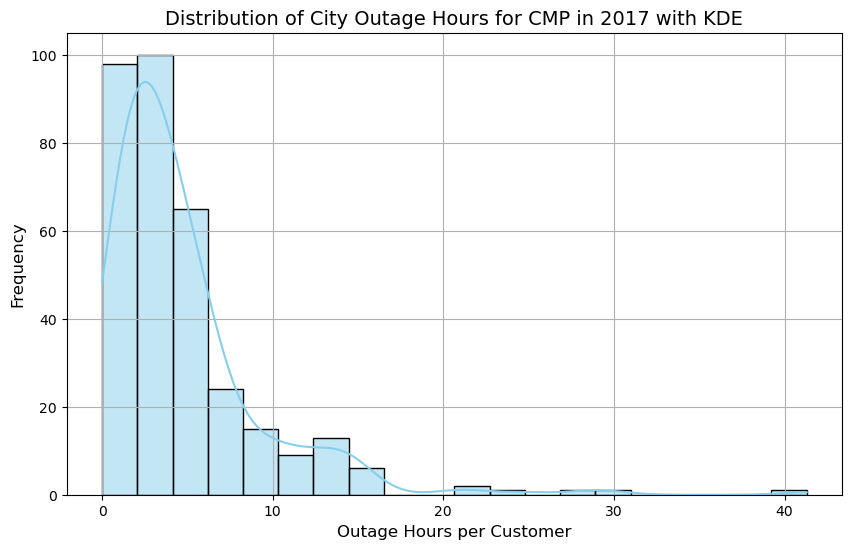

In [132]:
# Create the box plot
temp_df = yearly_city_df.loc[(yearly_city_df['UtilityName'] == 'Central Maine Power') & (yearly_city_df['RecordYear'] == 2017)]
temp_df['LogOutageHours'] = np.log1p(temp_df['OutageHoursPerCustomer'])

# Create the histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=temp_df, x='OutageHoursPerCustomer', kde=True, bins=20, color='skyblue')

# Customize the plot
plt.title('Distribution of City Outage Hours for CMP in 2017 with KDE', fontsize=14)
plt.xlabel('Outage Hours per Customer', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Show the plot
plt.savefig('exports/city-out-hours-dist.png', dpi=300)
plt.show()

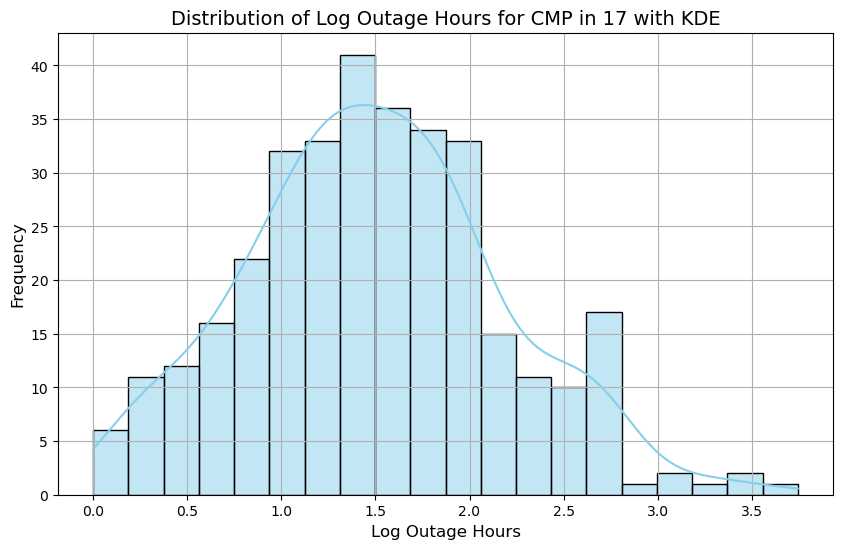

In [133]:
# Create the box plot
temp_df = yearly_city_df.loc[(yearly_city_df['UtilityName'] == 'Central Maine Power') & (yearly_city_df['RecordYear'] == 2017)]
temp_df['LogOutageHours'] = np.log1p(temp_df['OutageHoursPerCustomer'])

# Create the histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=temp_df, x='LogOutageHours', kde=True, bins=20, color='skyblue')

# Customize the plot
plt.title('Distribution of Log Outage Hours for CMP in 2017 with KDE', fontsize=14)
plt.xlabel('Log Outage Hours', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Show the plot
plt.savefig('exports/city-log-out-hours-dist.png', dpi=300)
plt.show()

### Plot average yearly outage hours per customer by utility provider 

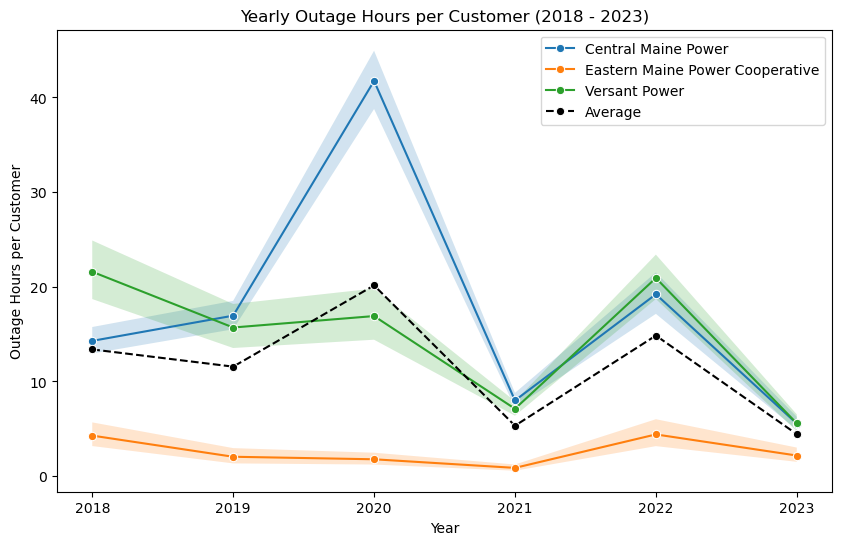

In [134]:
# Calculate the average outage hours per year
avg_outage_per_year = results_df.groupby('Year')['MeanOutageHours'].mean().reset_index()
avg_outage_per_year['UtilityProvider'] = 'Average' 

# plot the data
plt.figure(figsize=(10,6))
sns.lineplot(data=results_df, x='Year', y='MeanOutageHours', hue='UtilityProvider', marker="o")

# Plot the average outage hours per year on the same chart
sns.lineplot(data=avg_outage_per_year, x='Year', y='MeanOutageHours', color='black', label='Average', marker="o", linestyle='--')

# Plotting the confidence interval as a shaded area
for utility in results_df['UtilityProvider'].unique():
    subset = results_df[results_df['UtilityProvider'] == utility]
    plt.fill_between(subset['Year'], subset['CI_Lower'], subset['CI_Upper'], alpha=0.2)
    
# add labels
plt.title('Yearly Outage Hours per Customer (2018 - 2023)')
plt.ylabel('Outage Hours per Customer')
plt.xlabel('Year')

plt.savefig('exports/sample-utility-cust-out-hours-2018-2023.png', dpi=300)
plt.show()

#### Plot using direct calculations

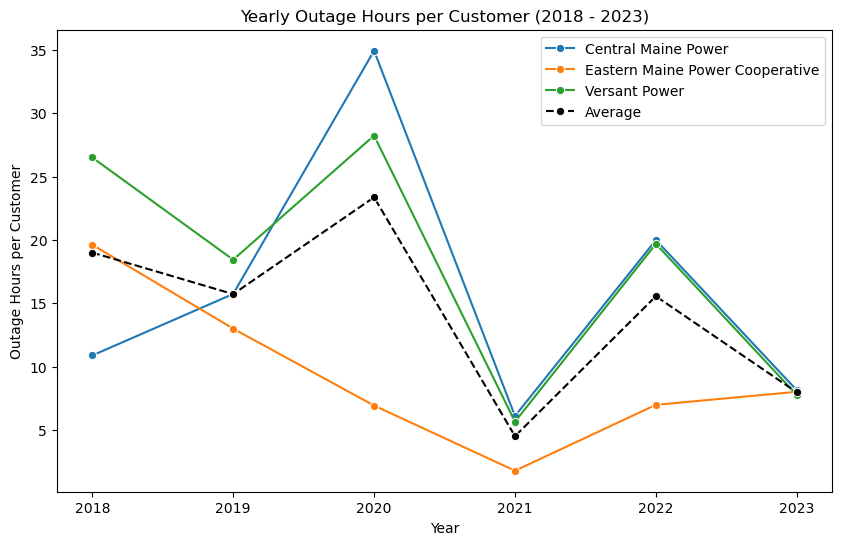

In [135]:

# sum up all the customers tracked and total customer hours by month and utility provider
monthly_utility_plot_df = df.groupby(['UtilityName', 'RecordYear', 'RecordMonth']).agg({'CustomerHoursOutTotal': 'sum', 'Customers': 'sum'}).reset_index()

# sum up total customer hours out by year and utility provider and average the customers tracked (to avoid double counting)
yearly_utility_plot_df = monthly_utility_plot_df.groupby(['UtilityName', 'RecordYear']).agg({'CustomerHoursOutTotal': 'sum', 'Customers': 'mean'}).reset_index()

# get the yearly outage hours per customer for each utility provider
yearly_utility_plot_df['OutageHoursPerCustomer'] = yearly_utility_plot_df['CustomerHoursOutTotal'] / yearly_utility_plot_df['Customers']

# Eastern Maine Power Cooperative only has data from 2018 onwards, removing data from 2017 and earlier for consistency
yearly_utility_plot_df.drop(yearly_utility_plot_df[yearly_utility_plot_df['RecordYear'] <= 2017].index, inplace=True)

# Calculate the average outage hours per year
avg_outage_direct = yearly_utility_plot_df.groupby('RecordYear')['OutageHoursPerCustomer'].mean().reset_index()
avg_outage_direct['UtilityProvider'] = 'Average' 

# plot the data
plt.figure(figsize=(10,6))
sns.lineplot(data=yearly_utility_plot_df, x='RecordYear', y='OutageHoursPerCustomer', hue='UtilityName', marker="o")

# Plot the average outage hours per year on the same chart
sns.lineplot(data=avg_outage_direct, x='RecordYear', y='OutageHoursPerCustomer', color='black', label='Average', marker="o", linestyle='--')

# add labels
plt.title('Yearly Outage Hours per Customer (2018 - 2023)')
plt.ylabel('Outage Hours per Customer')
plt.xlabel('Year')

plt.savefig('exports/direct-utility-cust-out-hours-2018-2023.png', dpi=300)
plt.show()


### Create a choropleth map of average outage hours per customer by city

In [136]:
# sum up total customer hours out by year and county and average the customers tracked (to avoid double counting)
yearly_city_df = df.groupby(['RecordYear', 'UtilityName', 'CityName']).agg({'CustomerHoursOutTotal': 'sum', 'Customers': 'mean'}).reset_index()

# get the yearly outage hours per customer for each city
yearly_city_df['OutageHoursPerCustomer'] = yearly_city_df['CustomerHoursOutTotal'] / yearly_city_df['Customers']

# sort by city and year
yearly_city_df.sort_values(by=['CityName', 'RecordYear'], inplace=True)

# update all city names to have the same formatting
yearly_city_df['CityName'] = yearly_city_df['CityName'].str.title()

# rename columns to be more readable
yearly_city_df.rename(columns={"CityName": "City", "RecordYear": "Year", "UtilityName": "Utility Provider", "OutageHoursPerCustomer": "Yearly Outage Hours per Customer"}, inplace=True)

# export and show dataframe
yearly_city_df

,Year,Utility Provider,City,CustomerHoursOutTotal,Customers,Yearly Outage Hours per Customer
2979,2021,Central Maine Power,Alfred,0.00,1.000000,0.000000
3729,2022,Central Maine Power,Alfred,0.00,1.000000,0.000000
4491,2023,Central Maine Power,Alfred,0.00,1.000000,0.000000
2980,2021,Central Maine Power,Auburn,10.10,1.125000,8.977778
3730,2022,Central Maine Power,Auburn,0.00,1.000000,0.000000
...,...,...,...,...,...,...
1982,2019,Central Maine Power,York,185476.41,11255.583333,16.478614
2610,2020,Central Maine Power,York,108489.98,10612.333333,10.223009
3346,2021,Central Maine Power,York,111309.84,10641.000000,10.460468
4102,2022,Central Maine Power,York,224831.34,10758.583333,20.897857


In [137]:
# get the overall yearly average outage hours per customer by county
overall_city_outage_df = yearly_city_df.groupby(['City']).agg({'Yearly Outage Hours per Customer': 'mean', 'Utility Provider': lambda x: ', '.join(x.unique())}).reset_index()

# sort county names alphabetically
overall_city_outage_df.sort_values(by=['City'], inplace=True)

# when aggregated, duplicate utility providers sometimes appear - remove all duplicates
overall_city_outage_df["Utility Provider"] = overall_city_outage_df["Utility Provider"].apply(remove_duplicate_providers)

#rename columns to be more readable
overall_city_outage_df.rename(columns={"CountyName": "County", "Yearly Outage Hours per Customer": "Average Yearly Outage Hours per Customer (2016 - 2023)", "UtilityName": "Utility Provider(s)"}, inplace=True)

# export and show dataframe
overall_city_outage_df

,City,Average Yearly Outage Hours per Customer (2016 - 2023),Utility Provider
0,Abbot,25.352569,Central Maine Power
1,Acton,20.793491,Central Maine Power
2,Adamstown,27.436739,Central Maine Power
3,Addison,16.029556,Versant Power
4,Albany,31.754999,Central Maine Power
...,...,...,...
744,Woolwich,28.368283,Central Maine Power
745,Wyman,11.585838,Central Maine Power
746,Wytopitlock,0.028085,Eastern Maine Power Cooperative
747,Yarmouth,10.178888,Central Maine Power


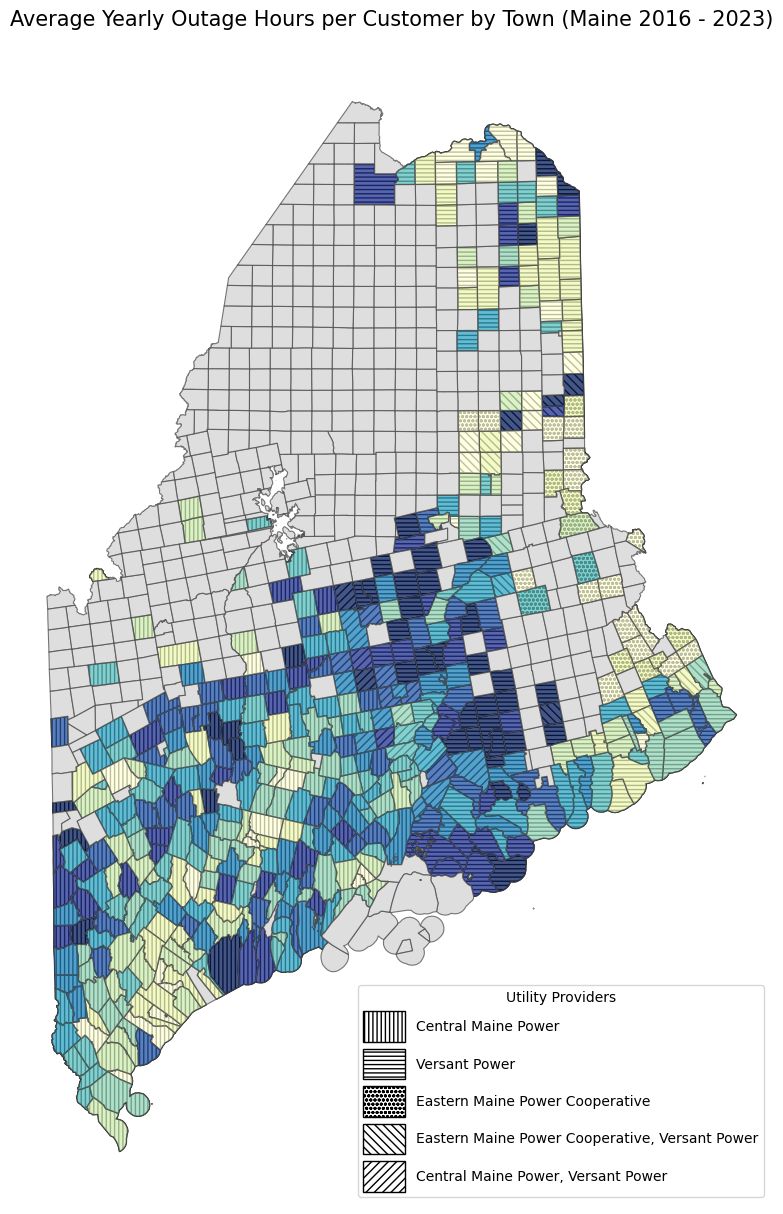

In [138]:
# import county boundaries
towns = gpd.read_file('../data/Maine_Town_and_Townships_Boundary_Polygons_Dissolved_Feature.shp')

# merge county outage hours per customer data with geospatial data
towns_merged = towns.set_index('TOWN').join(overall_city_outage_df.set_index('City'))

# configure the plot size
fig, ax = plt.subplots(figsize=(15, 15))
# add hatches for different utility providers
towns_merged.loc[towns_merged['Utility Provider'] == 'Central Maine Power'].plot(facecolor=(0, 0, 0, 0), hatch="||||", edgecolor="0.0", ax=ax)
towns_merged.loc[towns_merged['Utility Provider'] == 'Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch="----", edgecolor="0.0", ax=ax)
towns_merged.loc[towns_merged['Utility Provider'] == 'Eastern Maine Power Cooperative'].plot(facecolor=(0, 0, 0, 0), hatch="oooo", edgecolor="0.0", ax=ax)
towns_merged.loc[towns_merged['Utility Provider'] == 'Eastern Maine Power Cooperative, Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch="\\\\\\\\", edgecolor="0.0", ax=ax)
towns_merged.loc[towns_merged['Utility Provider'] == 'Central Maine Power, Versant Power'].plot(facecolor=(0, 0, 0, 0), hatch="////", edgecolor="0.0", ax=ax)
# plot the choropleth map using the outage hours per customer as a variable
towns_merged.plot(column='Average Yearly Outage Hours per Customer (2016 - 2023)', missing_kwds={'color': 'lightgrey'}, scheme='quantiles', alpha=0.75, cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True, legend_kwds={'loc': 'upper right'}, k=10)

# create custom legend of the hatches used
hatch_legend = [
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="||||", label="Central Maine Power"),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="----", label='Versant Power'),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="oooo", label='Eastern Maine Power Cooperative'),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="\\\\\\\\", label='Eastern Maine Power Cooperative, Versant Power'),
    mpatches.Patch(facecolor=(0, 0, 0, 0), edgecolor="0", hatch="////", label='Central Maine Power, Versant Power'),
]

# add the legend to the plot
ax.legend(handles=hatch_legend, title="Utility Providers", handleheight=3, handlelength=3, loc="lower right")

# axis customization
ax.set_title('Average Yearly Outage Hours per Customer by Town (Maine 2016 - 2023)', fontdict={'fontsize': '15', 'fontweight' : '3'}, loc='center')
ax.axis('off')

# save the map and display it within the notebook
plt.savefig('exports/in-progress-maine-city-map-out-hours.png', dpi=300)
plt.show()